<a href="https://colab.research.google.com/github/jahelsantiago/tensorflow_tutorial/blob/master/SUNspot_predictios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
import seaborn as sns
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-09-20 02:16:30--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 173.194.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.002s  

2020-09-20 02:16:30 (41.6 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [3]:
df_sun = pd.read_csv(r"/tmp/sunspots.csv")
df_sun

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3230,3230,2018-03-31,2.5
3231,3231,2018-04-30,8.9
3232,3232,2018-05-31,13.2
3233,3233,2018-06-30,15.9


In [4]:
series = df_sun.iloc[:,2].values
time = df_sun.iloc[:,0].values

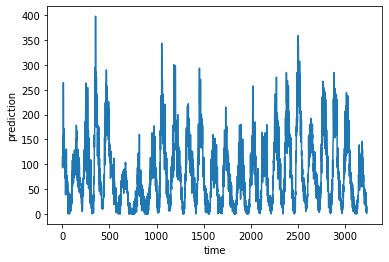

In [5]:
plt.xlabel("time")
plt.ylabel("prediction")
plt.plot(time, series)

Dividimos en train y test los 3235 datos en
split 2700

In [6]:
split = 2700
series_train = series[:split]
series_val = series[split:]
time_trian = series[:split]
time_val = series[split:]

generasmos el data set

In [7]:
from tensorflow.data import Dataset
def generate_windowed_dataset(series, windowsize, batchsize):
  series = tf.expand_dims(series, -1)
  ds = Dataset.from_tensor_slices(series)
  ds = ds.window(windowsize, 1,1,True)
  ds = ds.flat_map( lambda x: x.batch(windowsize))
  ds = ds.shuffle(1000)
  ds = ds.map(lambda x: (x[:-1], x[-1:]))
  ds = ds.batch(batchsize).prefetch(1)
  return ds

In [22]:
from tensorflow.keras import layers

tf.keras.backend.clear_session()
window_size = 64
batch_size = 256
train_set = generate_windowed_dataset(series_train, window_size, batch_size)

#creamos nuestro modelo
model = tf.keras.models.Sequential([
  layers.Conv1D(32,12,1,"causal",activation ="relu", input_shape=(None, 1)),
  layers.LSTM(64,return_sequences=True),
  layers.LSTM(64,return_sequences=True),
  layers.Dense(32, activation = "relu"),
  layers.Dense(10, activation = "relu"),
  layers.Dense(1, activation = "relu"),
  layers.Lambda(lambda x: x*400)
])

lr_shedule = tf.keras.callbacks

compilamos el modelo

In [23]:
from tensorflow.keras import layers
lr_shedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer, metrics=["mae"])

corremos el primer acercamiento de el modelos

In [ ]:
history = model.fit(train_set,epochs = 100, callbacks = [lr_shedule])

avriguamos el learning rate optimo

(1e-05, 0.0001, 35.0, 45.0)

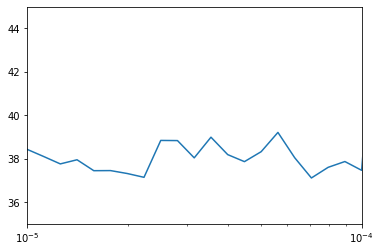

In [44]:
y=history.history["loss"]
x=history.history["lr"]

plt.semilogx(x,y)
plt.axis([1e-5,1e-4,35,45])

In [ ]:
0